![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

### Task: 

The liquidity position of a firm measured in million is a **generalized Wiener process** with a drift of $0.1$ per month and a variance of $\sigma^2 = 0.16$ per month. The initial cash position is $2.0$. Calculate:

1. 	the expected value and standard deviation in one, six and 12 months.
2.	What is the probability of a negative cash position in 6 and 12 months? 

Probability of illiquidity in  6 month: 0.3982%
Probability of illiquidity in 12 month: 1.0461%
Probability of illiquidity in 36 month: 0.9815%


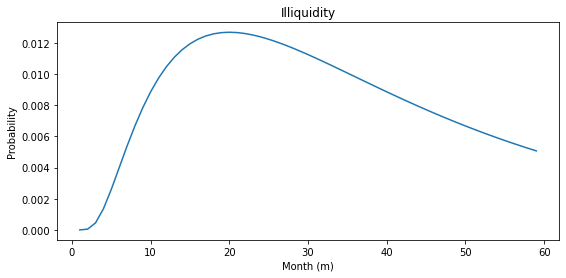

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def prob_illiquid(m, const=2, drift=.1, variance=.16):
    expected_cash = (const + drift * m)
    sigma = (variance * m)**0.5
    p_illiquid = norm.cdf( (0 - expected_cash) / sigma ,0,1)  # normalization: (x - mu) / sigma
    return p_illiquid

print(f"Probability of illiquidity in  6 month: {prob_illiquid(6)*100:.4f}%")
print(f"Probability of illiquidity in 12 month: {prob_illiquid(12)*100:.4f}%")
print(f"Probability of illiquidity in 36 month: {prob_illiquid(36)*100:.4f}%")

# The figure is not required
X = range(1,12*5, 1)
fX = list(map(lambda m: prob_illiquid(m), X))

plt.figure('Illiquidity', figsize=(9,4))
plt.title("Illiquidity")
plt.plot(X, fX)
plt.xlabel("Month (m)")
plt.ylabel("Probability")
plt.show()

-1

In [88]:
# Alternative: Monte Carlo solution (not asked)
import numpy as np

# Parameters
const=2
drift=.1
variance=.16
m = 12
n = 100000
np.random.seed(123)
z = np.random.normal(0, 1, n)

# Simulate cash position (generalized Wiener process)
simulated_cash = const + drift * m + (variance * m)**0.5 * z 
# 1_{cash < 0}
p_illiquid_mc = np.mean( (simulated_cash < 0) * 1 )

print(f"Probability of illiquidity in 12 month approx.: {p_illiquid_mc*100:.4f}%")

Probability of illiquidity in 12 month approx.: 1.0290%


### Task: 

The cash flow of a [call option](https://en.wikipedia.org/wiki/Call_option) with strike $K$ at maturity $T$ is given by

$$
max(S_T - K, 0) = (S_T - K)^+
$$

where $S_T$ is the price of the underlying at $T$. The price of the option under the [risk-neutral measure](https://en.wikipedia.org/wiki/Risk-neutral_measure) $\mathbb{Q}$ is simply its discounted expected value
$$
\mathbb{E}^\mathbb{Q}[(S_T - K)^+] e^{-rT}.
$$


Calculate the price of the option, using:
1. numerical integration and
2. Monte carlo simulation.

For you calculations, assume that todays price of the underlying is $S_0 = 220$, the strike is $K = 220$, volatility is $\sigma = 0.98$, the risk free rate is $r = 10\%$ (continuous) and maturity is one year. We further assume that the underlying $S$ follows a **Geometric Brownian motion**.

Hint: The terminal stock price $S_T$, under the risk-neutral measure, follows a log-normal distribution with PDF

$$f(x) = \frac{1}{x s \sqrt{2 \pi}} \exp\left( -\frac{(\ln x - \mu)^2}{2 s^2} \right) $$

where $\mu = \ln S_0 + (r-\sigma^2 / 2)T$ and variance $s^2 = \sigma^2 T$.


In [89]:
# Inputs
S_0   = 220  # price of the underlying
K     = 220  # strike price
sigma = .98  # volatility
rate  = 0.1  # risk free rate
T     = 1    # time to maturity

Straightforward integration: 89.6014
Black-Scholes price        : 89.6014
AoN - CoN                  : 89.6014


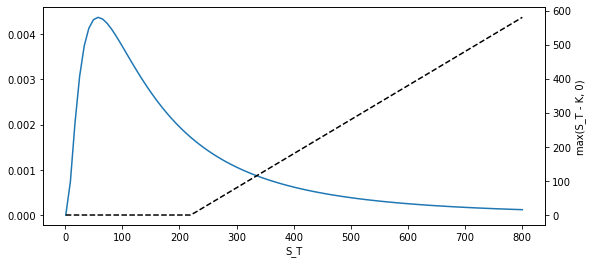

In [90]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt

# The famous Black-Scholes model (we use this as a benchmark)
def black_scholes(cpflag,S,K,T,r,sigma):
    # cpflag in {1 for call, -1 for put}
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    price = cpflag * (S * norm.cdf(cpflag*d1, 0.0, 1.0) - K * np.exp(-r * T) * 
            norm.cdf(cpflag*d2, 0.0, 1.0))
    return price

# expected value of (S_T - K)
def E2dF(S, S_0, rf, sd, t, K):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return (S - K) * A * B
# straight forward integration
Call = quad(lambda x: E2dF(x, S_0, rate, sigma, T, K), K, +np.inf)[0] * np.exp(-rate*T)

# expected value S_T
def EdF(S, S_0, rf, sd, t):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return S * A * B
# asset or nothing
AoN = quad(lambda x: EdF(x, S_0, rate, sigma, T), K, +np.inf)[0] * np.exp(-rate*T)

# probability P(S_T > K)
def PdF(S, S_0, rf, sd, t):
    A = 1 / ( np.sqrt(2*np.pi*t)*sd*S)
    B = np.exp(-(np.log(S)-(np.log(S_0)+(rf-0.5*sd**2)*t))**2/(2*sd**2*t))
    return A * B
# cash or nothing with cash = K
CoN = K * quad(lambda x: PdF(x, S_0, rate, sigma, T), K, +np.inf)[0] * np.exp(-rate*T)

print(f"Straightforward integration: {Call:.4f}")
print(f"Black-Scholes price        : {black_scholes(1,S_0,K,T,rate,sigma):.4f}")
print(f"AoN - CoN                  : {AoN-CoN:.4f}")

# Plotting
x = np.linspace(1, 800, 100)
fig, ax1 = plt.subplots(figsize=(9,4))
ax1.plot(x, PdF(x, S_0, rate, sigma, T))
ax1.set_xlabel('S_T')
ax2 = ax1.twinx()
ax2.plot(x, np.maximum(x-K,0), '--', color="black")
ax2.set_ylabel('max(S_T - K, 0)')
plt.show()

In [132]:
Nsim = 1000000

# Normally distributed random numbers
np.random.seed(123)
Z = np.random.normal(0, 1, Nsim)
# Geometric Brownian motion
S_T = S_0 * np.exp(Z * sigma * np.sqrt(T) + (rate-0.5*sigma**2) * T)
# Simulated option payouts
CF_T = np.maximum((S_T - K),0)

# Discounted expected cash flow
price = np.mean(CF_T) * np.exp(-rate*T)
# With 95% confidence
price_upper = price + 1.96 * np.std(CF_T)/np.sqrt(Nsim) * np.exp(-rate*T)
price_lower = price - 1.96 * np.std(CF_T)/np.sqrt(Nsim) * np.exp(-rate*T)

# Format and print output
print(f"Price of the call option: {price:,.2f}")
print(f"Confidence level 95%: {price_lower:,.2f} < price < {price_upper:,.2f}")


Price of the call option: 89.72
Confidence level 95%: 89.24 < price < 90.20
